In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
# Additional libraries like os, PIL for image handling might be required


In [7]:
class ModifiedResNetCAM(nn.Module):
    def __init__(self):
        super(ModifiedResNetCAM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])
        self.num_ftrs = self.resnet.fc.in_features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.num_ftrs, 1)

    def forward(self, x):
        x = self.features(x)
        self.feature_maps = x
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x)

model = ModifiedResNetCAM()


/Users/fanrongqi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fanrongqi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
def generate_cam(feature_maps, weight_softmax, target_class):
    bz, nc, h, w = feature_maps.shape
    output_cam = []
    cam = weight_softmax.dot(feature_maps.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam_img = np.uint8(255 * cam)
    output_cam.append(cv2.resize(cam_img, (224, 224)))
    return output_cam


torch.Size([1, 3, 224, 224])


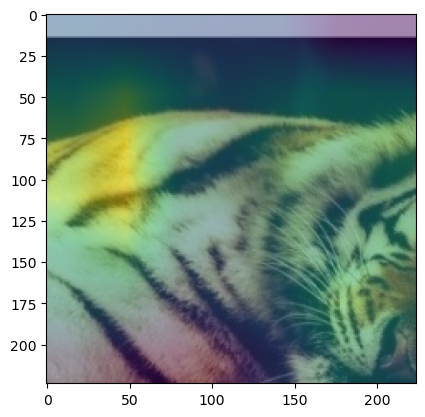

In [29]:
def visualize_cam(model, image_path):
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)
    print(img_tensor.shape)

    # Get the model output
    model.eval()
    output = model(img_tensor)

    # Get the weights of the final layer
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.numpy())

    # Generate CAM
    cam = generate_cam(model.feature_maps.data.numpy(), weight_softmax, output.data.numpy())
    
    # Display the original image and CAM overlay
    plt.imshow(img)
    # print(img.shape)
    plt.imshow(cam[0], alpha=0.5)
    plt.show()

# Example usage
visualize_cam(model, 'tiger.jpeg')
